In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer

In [2]:
dataset=pd.read_csv("dataset.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (56,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
dataset=dataset.replace({"--":np.nan})
#dataset.describe()

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39961 entries, 0 to 39960
Data columns (total 71 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sample                    39961 non-null  int64  
 1   ID                        39961 non-null  int64  
 2   DATA                      39961 non-null  int64  
 3   LONGITUDE                 39961 non-null  int64  
 4   LATITUDE                  39961 non-null  int64  
 5   City                      39961 non-null  object 
 6   Postal Code               39955 non-null  object 
 7   Community                 39961 non-null  object 
 8   Property Type             39961 non-null  object 
 9   Building Style            39913 non-null  object 
 10  Bedrooms AG               39888 non-null  float64
 11  Bedrooms BG               18701 non-null  float64
 12  Washrooms                 39961 non-null  int64  
 13  Kitchen                   39887 non-null  float64
 14  Family

In [5]:
def convert_date(date):
    try:
        return  datetime.strptime(date,'%m/%d/%Y' )    
    except: 
        try:   
            return  datetime.strptime(date, '%d/%m/%Y')
        except:
            #print(date)
            return np.nan
    

def convert_month(date):
    return (date.year-2016)*12+(date.month-1)

dataset['Sold Date']=[convert_date(X) for X in dataset['Sold Date'].tolist()]
dataset['Date']=[convert_month(X) for X in dataset['Sold Date'].tolist()]

In [6]:
mortgage=pd.read_csv("book3.csv").dropna()
#mortgage["Date"]=[datetime.strptime(X,'%b-%y' ) for X in mortgage["Jul-110 *M Disaggregate_All"].tolist()]
#mortgage["Date"]=[convert_month(X) for X in mortgage["Date"].tolist()]
#mortgage=mortgage[mortgage["Date"]>=0]
#mortgage=mortgage[mortgage["Date"]<25]
#mortgage["MortgageRate"]=mortgage["V122520@CANADA"]
#mortgage=mortgage.drop(["Jul-110 *M Disaggregate_All","V122520@CANADA"],axis=1)
dataset["MortgageRate"]=[mortgage["V122520@CANADA"][d+66] for d in dataset["Date"].values]

In [7]:
dataset[["MortgageRate","Date"]]


,MortgageRate,Date
0,3.14,10
1,3.14,7
2,3.14,9
3,3.14,9
4,3.14,2
...,...,...
39956,3.24,22
39957,3.14,10
39958,3.24,22
39959,3.14,14


In [8]:
amenities_list=dataset[['Amenities 1', 'Amenities 2', 'Amenities 3', 'Amenities 4', 'Amenities 5', 'Amenities 6']].fillna("None").values
#The TransactionEncoder returna  a "True" and "False" Matrix.
te = TransactionEncoder()
te_ary = te.fit(amenities_list).transform(amenities_list)
#convert all "bool" type to "int".
te_ary=te_ary.astype("int")
amenities_df=pd.DataFrame(te_ary, columns=te.columns_).drop("None",axis=1)
dataset[list(amenities_df.columns)]=amenities_df

In [9]:
temp_dataset=dataset[['ID','Postal Code','LONGITUDE', 'LATITUDE','Latitude:1', 'Longtitude','Expirey Date','Terminated Date','Suspended Date','Closing Date',"Community","neighbourhood_ID","Ward"]]


In [10]:
dataset=dataset.drop(['Sample', 'City','Status','Status Auto','Region','Transaction Type',"Kitchen"],axis=1) # low varience
dataset=dataset.drop(['DATA','Postal Code','LONGITUDE', 'LATITUDE','Latitude:1', 'Longtitude'],axis=1) #No info
dataset=dataset.drop(["Picture Exists",'Corp #','Management Company','green_date'],axis=1)
dataset=dataset.drop(['Expirey Date','Terminated Date','Suspended Date','Closing Date','Contract Date', 'Sold Date'],axis=1)
dataset=dataset.drop(["Community",'neighbourhood_ID','neighbourhood_name'],axis=1) #equal to neighbourhood_name  
dataset=dataset.drop(["Age Range","Locker Unit","Parking Spot"],axis=1) # miss value
dataset=dataset.drop(['Amenities 1', 'Amenities 2', 'Amenities 3', 'Amenities 4', 'Amenities 5', 'Amenities 6'],axis=1) # converted

In [11]:
dataset['Bedrooms BG']=dataset['Bedrooms BG'].fillna(0) #fill miss value with zero
dataset['Bedrooms AG']=dataset['Bedrooms AG'].fillna(0) #fill miss value with zero
dataset['Family Room']=dataset['Family Room'].fillna(0) #fill miss value with zero
dataset['Basement']=dataset['Basement'].fillna("None") #fill miss value with "None": dont have any basement
dataset["Heat Source"]=dataset["Heat Source"].fillna("Other") #fill miss value with "Other"

In [12]:
# problem in .csv file string instead of num
# convert sring to int

In [13]:
def convert_toInt(num):
    try:
        return int(float(num))
    except:
        return np.nan  
    
dataset["Sale to List %"]=[convert_toInt(X) for X in dataset["Sale to List %"].tolist()]
dataset['Maint. Fees']=[convert_toInt(X) for X in dataset['Maint. Fees'].tolist()]
dataset['Total Rooms']=[convert_toInt(X) for X in dataset['Total Rooms'].tolist()]
dataset['Family Room']=[convert_toInt(X) for X in dataset['Family Room'].tolist()]
dataset['Common Elements Included']=[convert_toInt(X) for X in dataset['Common Elements Included'].tolist()]
dataset['Taxes Included']=[convert_toInt(X) for X in dataset['Taxes Included'].tolist()]
dataset['Heat included']=[convert_toInt(X) for X in dataset['Heat included'].tolist()]
dataset['Water Included']=[convert_toInt(X) for X in dataset['Water Included'].tolist()]
dataset['Hydro Included']=[convert_toInt(X) for X in dataset['Hydro Included'].tolist()]
dataset['Parking Included']=[convert_toInt(X) for X in dataset['Parking Included'].tolist()]
dataset['Ensuite Laundry']=[convert_toInt(X) for X in dataset['Ensuite Laundry'].tolist()]


In [14]:
print('Ownership Type:')
print("Condo:",set(dataset[dataset['Ownership Type']=='Condo']['Property Type']))
print("Free:",set(dataset[dataset['Ownership Type']=='Free']['Property Type']))

Ownership Type:
Condo: {'Leasehold Condo', 'Semi-Det Condo', 'Condo Townhouse', 'Parking Space', 'Comm Element Condo', 'Det Condo', 'Co-Op Apt', 'Locker', 'Co-Ownership Apt', 'Other', 'Condo Apt'}
Free: {'Semi-Detached', 'Vacant Land', 'Fourplex', 'Detached', 'Duplex', 'Det W/Com Elements', 'Multiplex', 'Att/Row/Twnhouse', 'Triplex', 'Other', 'Store W/Apt/Offc', 'Link'}


In [15]:
dataset.columns

Index(['ID', 'Property Type', 'Building Style', 'Bedrooms AG', 'Bedrooms BG',
       'Washrooms', 'Family Room', 'Basement', 'Exposure', 'Square Feet',
       'Parking Type', 'Taxes', 'Maint. Fees', 'AC Type', 'Heat Type',
       'Common Elements Included', 'Taxes Included', 'Heat included',
       'Water Included', 'Hydro Included', 'Parking Included',
       'Ensuite Laundry', 'Locker', 'Balcony', 'List Price', 'Sold Price',
       'Days on Market', 'Pets Permitted', 'Original Price', 'Heat Source',
       'Hold Over Days', 'Total Rooms', 'Ownership Type', 'Sale to List %',
       'Ward', 'green_new', 'Date', 'MortgageRate', 'Bbqs Allowed',
       'Bike Storage', 'Bus Ctr (Wifi Bldg)', 'Car Wash', 'Concierge',
       'Exercise Room', 'Games Room', 'Guest Suites', 'Gym', 'Indoor Pool',
       'Lap Pool', 'Media Room', 'Outdoor Pool', 'Party/Meeting Room',
       'Recreation Room', 'Rooftop Deck/Garden', 'Satellite Dish', 'Sauna',
       'Security Guard', 'Security System', 'Squash/Rac

In [16]:
#House type and house attributes
House_Type=['Duplex', 'Semi-Detached', 'Triplex','Multiplex','Fourplex','Link','Att/Row/Twnhouse','Detached']
House_Attributes=['Property Type', 'Building Style', 'Bedrooms AG', 'Bedrooms BG','Washrooms','Family Room', 
       'Basement','Parking Type','Taxes','AC Type','Heat Source','Total Rooms','Ward',
        'green_new','Date',"MortgageRate",'Sale to List %','Days on Market','List Price', 'Sold Price'] 

In [17]:
House_dataset=dataset[dataset["Property Type"].isin(House_Type)]
House_dataset=House_dataset[House_Attributes]

In [18]:
is_NaN = House_dataset.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = House_dataset[row_has_NaN]
rows_with_NaN

,Property Type,Building Style,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Basement,Parking Type,Taxes,AC Type,Heat Source,Total Rooms,Ward,green_new,Date,MortgageRate,Sale to List %,Days on Market,List Price,Sold Price
1917,Detached,Bungalow,3.0,2.0,2,1,Finished,None,13135.06,Central Air,Gas,5.0,C04,32.469583,22,3.24,NaN,49,100,2000000
7809,Detached,NaN,0.0,0.0,0,0,None,NaN,4800.00,NaN,Other,NaN,C07,36.657604,1,3.14,95.0,2,1088000,1030000
17579,Semi-Detached,2-Storey,3.0,0.0,4,0,Finished,None,3498.00,Central Air,Gas,6.0,W02,10.580400,4,3.14,NaN,10,1,655000


In [19]:
# drop collom contine miss value

In [20]:
House_dataset=House_dataset.dropna() 

## House_dataset

In [21]:
#House_dataset=House_dataset[House_dataset['Sold Price']<1525000]
#House_dataset=House_dataset[House_dataset['Sold Price']>125000]

In [22]:
print(House_dataset.columns)

Index(['Property Type', 'Building Style', 'Bedrooms AG', 'Bedrooms BG',
       'Washrooms', 'Family Room', 'Basement', 'Parking Type', 'Taxes',
       'AC Type', 'Heat Source', 'Total Rooms', 'Ward', 'green_new', 'Date',
       'MortgageRate', 'Sale to List %', 'Days on Market', 'List Price',
       'Sold Price'],
      dtype='object')


In [23]:
House_dataset['Property Type'].value_counts()

Detached            11412
Semi-Detached        3384
Att/Row/Twnhouse     1188
Link                  111
Duplex                 81
Triplex                41
Multiplex              33
Fourplex               11
Name: Property Type, dtype: int64

In [24]:
House_dataset['Property Type']=House_dataset['Property Type'].replace("Att/Row/Twnhouse","Other house Property")
House_dataset['Property Type']=House_dataset['Property Type'].replace("Link","Other house Property")
House_dataset['Property Type']=House_dataset['Property Type'].replace("Duplex","Other house Property")
House_dataset['Property Type']=House_dataset['Property Type'].replace("Triplex","Other house Property")
House_dataset['Property Type']=House_dataset['Property Type'].replace("Multiplex","Other house Property")
House_dataset['Property Type']=House_dataset['Property Type'].replace("Fourplex","Other house Property")
House_dataset['Property Type'].value_counts()

Detached                11412
Semi-Detached            3384
Other house Property     1465
Name: Property Type, dtype: int64

In [25]:
House_dataset['Detached']=(House_dataset['Property Type']=="Detached").astype(int)
House_dataset['Semi-Detached']=(House_dataset['Property Type']=="Semi-Detached").astype(int)
House_dataset['Other house Property']=(House_dataset['Property Type']=="Other house Property").astype(int)
House_dataset=House_dataset.drop('Property Type',axis=1)

In [26]:
House_dataset['Building Style'].value_counts()

2-Storey           7806
Bungalow           3806
3-Storey           1285
2 1/2 Storey        750
1 1/2 Storey        675
Bungalow-Raised     569
Backsplit 4         365
Sidesplit 4         281
Backsplit 3         256
Backsplit 5         199
Sidesplit 3         178
Sidesplit 5          40
Other                37
Bungaloft            13
Multi-Level           1
Name: Building Style, dtype: int64

In [27]:
House_dataset['Building Style']=House_dataset['Building Style'].replace("Multi-Level","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Other","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Bungaloft","Bungalow")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Sidesplit 5","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Sidesplit 3","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Backsplit 5","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Backsplit 3","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Sidesplit 4","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Backsplit 4","Other house Style")
House_dataset['Building Style']=House_dataset['Building Style'].replace("2 1/2 Storey","Multi Storey")
House_dataset['Building Style']=House_dataset['Building Style'].replace("1 1/2 Storey","Multi Storey")
House_dataset['Building Style']=House_dataset['Building Style'].replace("3-Storey","Multi Storey")
House_dataset['Building Style']=House_dataset['Building Style'].replace("2-Storey","Multi Storey")
House_dataset['Building Style']=House_dataset['Building Style'].replace("Bungalow-Raised","Bungalow")
House_dataset['Building Style'].value_counts()

Multi Storey         10516
Bungalow              4388
Other house Style     1357
Name: Building Style, dtype: int64

In [28]:
House_dataset['Multi Storey']=(House_dataset['Building Style']=="Multi Storey").astype(int)
House_dataset['Bungalow']=(House_dataset['Building Style']=="Bungalow").astype(int)
House_dataset['Other house Style']=(House_dataset['Building Style']=="Other house Style").astype(int)
House_dataset=House_dataset.drop('Building Style',axis=1)

In [29]:
House_dataset['Bedrooms AG'].value_counts().sort_index()

0.0      22
1.0     105
2.0    1834
3.0    8869
4.0    4271
5.0     879
6.0     182
7.0      40
8.0      36
9.0      23
Name: Bedrooms AG, dtype: int64

In [30]:
House_dataset=House_dataset[House_dataset['Bedrooms AG']<7]
House_dataset=House_dataset[House_dataset['Bedrooms AG']>0]
House_dataset['Bedrooms AG'].value_counts().sort_index()

1.0     105
2.0    1834
3.0    8869
4.0    4271
5.0     879
6.0     182
Name: Bedrooms AG, dtype: int64

In [31]:
House_dataset['Bedrooms BG'].value_counts().sort_index()

0.0    6969
1.0    6476
2.0    2226
3.0     411
4.0      52
5.0       5
6.0       1
Name: Bedrooms BG, dtype: int64

In [32]:
House_dataset=House_dataset[House_dataset['Bedrooms BG']<4]
House_dataset['Bedrooms BG'].value_counts()

0.0    6969
1.0    6476
2.0    2226
3.0     411
Name: Bedrooms BG, dtype: int64

In [33]:
House_dataset['Washrooms'].value_counts().sort_index()

0        2
1     1094
2     6811
3     4042
4     2611
5      961
6      338
7      147
8       49
9       17
10       8
11       2
Name: Washrooms, dtype: int64

In [34]:
House_dataset=House_dataset[House_dataset['Washrooms']<9]
House_dataset=House_dataset[House_dataset['Washrooms']>0]


In [35]:
House_dataset['Heat Source'].value_counts()

Gas          15403
Oil            339
Electric       224
Other           68
Grnd Srce       15
Wood             2
Propane          2
Name: Heat Source, dtype: int64

In [36]:
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Grnd Srce",0)
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Other",0)
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Oil",0)
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Wood",0)
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Propane",0)
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Electric",0)
House_dataset['Heat Source']=House_dataset['Heat Source'].replace("Gas",1)
House_dataset['Heat Source'].value_counts()

1    15403
0      650
Name: Heat Source, dtype: int64

In [37]:
House_dataset=House_dataset.drop('Heat Source',axis=1)

In [38]:
House_dataset['Parking Type'].value_counts()

Attached    4775
None        4597
Detached    3406
Built-In    2613
Carport      502
Other        160
Name: Parking Type, dtype: int64

In [39]:
House_dataset['Parking Type']=House_dataset['Parking Type'].replace("Other",1)
House_dataset['Parking Type']=House_dataset['Parking Type'].replace("Carport",0)
House_dataset['Parking Type']=House_dataset['Parking Type'].replace("Built-In",1)
House_dataset['Parking Type']=House_dataset['Parking Type'].replace("Detached",1)
House_dataset['Parking Type']=House_dataset['Parking Type'].replace("Attached",1)
House_dataset['Parking Type']=House_dataset['Parking Type'].replace("None",0)
House_dataset['Parking Type'].value_counts()

1    10954
0     5099
Name: Parking Type, dtype: int64

In [40]:
House_dataset['AC Type'].value_counts()

Central Air    13334
None            1743
Wall Unit        554
Window Unit      244
Other            178
Name: AC Type, dtype: int64

In [41]:
House_dataset['AC Type']=House_dataset['AC Type'].replace("Other",0)
House_dataset['AC Type']=House_dataset['AC Type'].replace("Wall Unit",0)
House_dataset['AC Type']=House_dataset['AC Type'].replace("Window Unit",0)
House_dataset['AC Type']=House_dataset['AC Type'].replace("None",0)
House_dataset['AC Type']=House_dataset['AC Type'].replace("Central Air",1)
House_dataset['AC Type'].value_counts()

1    13334
0     2719
Name: AC Type, dtype: int64

In [42]:
House_dataset['Basement'].value_counts()

Finished        8980
Apartment       1974
Fin W/O         1724
Part Fin        1099
Full             743
Unfinished       703
Sep Entrance     354
None             175
Crawl Space      155
Part Bsmt         69
Other             29
W/O               20
Half              15
Walk-Up           13
Name: Basement, dtype: int64

In [43]:
House_dataset['Basement']=House_dataset['Basement'].replace("Walk-Up","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("Half","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("W/O","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("Other","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("Part Bsmt","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("Crawl Space","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("Fin W/O","Finished")
House_dataset['Basement']=House_dataset['Basement'].replace("Full","Finished")
House_dataset['Basement']=House_dataset['Basement'].replace("Apartment","Finished")
House_dataset['Basement']=House_dataset['Basement'].replace("Sep Entrance","Other Basement type")
House_dataset['Basement']=House_dataset['Basement'].replace("Part Fin","Other Basement type")

In [44]:
House_dataset['Finished'] = (House_dataset['Basement']=='Finished').astype(int)
House_dataset['Unfinished'] = (House_dataset['Basement']=='Unfinished').astype(int)
House_dataset["Other Basement type"] = (House_dataset['Basement']=='Other Basement type').astype(int)
House_dataset['Basement']=House_dataset['Basement'].replace("Other",0)

In [45]:
House_dataset['Basement'].value_counts()

Finished               13421
Other Basement type     1754
Unfinished               703
None                     175
Name: Basement, dtype: int64

In [46]:
House_dataset=House_dataset.drop('Basement',axis=1)

In [47]:
House_dataset[['Taxes','Sold Price']].corr(method ='pearson')

,Taxes,Sold Price
Taxes,1.000000,0.813681
Sold Price,0.813681,1.000000


In [48]:
House_dataset[House_dataset['Taxes']!=0]['Taxes'].describe()

count    15751.000000
mean      4543.574539
std       3093.738507
min          1.000000
25%       2841.000000
50%       3639.380000
75%       5035.960000
max      56812.820000
Name: Taxes, dtype: float64

array([[<AxesSubplot:title={'center':'Taxes'}>]], dtype=object)

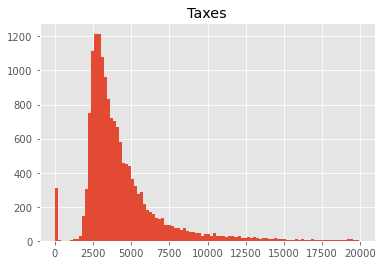

In [49]:
House_dataset[House_dataset['Taxes']<20000].hist('Taxes',bins=100)

In [50]:
House_dataset=House_dataset[House_dataset['Taxes']<15000]
House_dataset=House_dataset[House_dataset['Taxes']>1500]

array([[<AxesSubplot:title={'center':'Taxes'}>]], dtype=object)

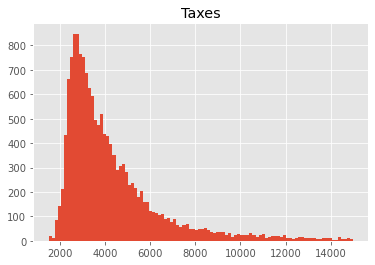

In [51]:
House_dataset.hist('Taxes',bins=100)

In [52]:
House_dataset[['Taxes','Sold Price']].corr(method ='pearson')

,Taxes,Sold Price
Taxes,1.000000,0.878971
Sold Price,0.878971,1.000000


In [53]:
House_dataset['Total Rooms'].value_counts().sort_index()

0.0        2
1.0        8
2.0        4
3.0       56
4.0      267
5.0     1445
6.0     5085
7.0     3169
8.0     2405
9.0     1497
10.0     841
11.0     340
12.0     221
13.0      47
14.0      38
15.0      23
16.0       8
17.0       5
18.0       1
19.0       1
20.0       3
21.0       1
23.0       1
Name: Total Rooms, dtype: int64

In [54]:
House_dataset=House_dataset.drop('Total Rooms',axis=1)

In [55]:
House_dataset['Sale to List %'].value_counts()

100.0     1303
98.0      1054
99.0      1052
97.0       925
96.0       686
          ... 
61.0         1
1422.0       1
171.0        1
174.0        1
189.0        1
Name: Sale to List %, Length: 106, dtype: int64

In [56]:
House_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15468 entries, 30 to 33757
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bedrooms AG           15468 non-null  float64
 1   Bedrooms BG           15468 non-null  float64
 2   Washrooms             15468 non-null  int64  
 3   Family Room           15468 non-null  int64  
 4   Parking Type          15468 non-null  int64  
 5   Taxes                 15468 non-null  float64
 6   AC Type               15468 non-null  int64  
 7   Ward                  15468 non-null  object 
 8   green_new             15468 non-null  float64
 9   Date                  15468 non-null  int64  
 10  MortgageRate          15468 non-null  float64
 11  Sale to List %        15468 non-null  float64
 12  Days on Market        15468 non-null  int64  
 13  List Price            15468 non-null  int64  
 14  Sold Price            15468 non-null  int64  
 15  Detached          

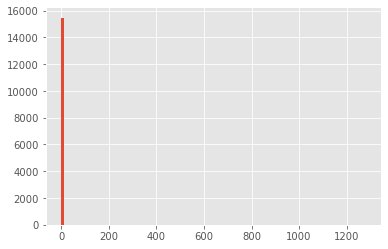

In [57]:
err=[abs(100*(float(b)/a)-c) for a,b,c in zip(House_dataset["List Price"],House_dataset["Sold Price"],House_dataset['Sale to List %'])]
plt.hist(err,bins=100)
plt.show()

In [58]:
print(sum([x>1 for x in err]))
House_dataset["err"]=err

1


In [59]:
House_dataset=House_dataset[House_dataset["err"]<1]
House_dataset=House_dataset.drop("err",axis=1)

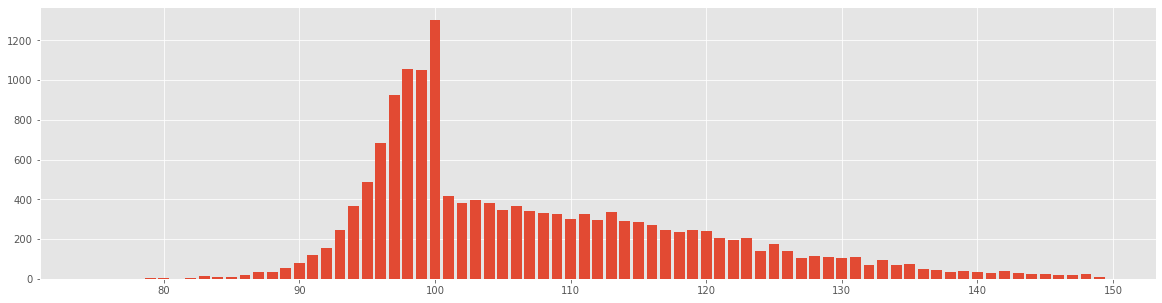

In [60]:
fig = plt.figure(figsize =(20,5))
ss=House_dataset['Sale to List %'].value_counts().sort_index()
ss=ss[ss.keys()<150]
ss=ss[ss.keys()>70]
plt.bar(list(ss.keys()),list(ss.values))
plt.show()

In [61]:
House_dataset=House_dataset[House_dataset["Sale to List %"]>70]

In [62]:
SS=House_dataset["Ward"].value_counts()
SS[SS.values < 50].keys()

Index([], dtype='object')

In [63]:
House_dataset=House_dataset[~(House_dataset["Ward"].isin(list(SS[SS.values < 50].keys())))]

In [64]:
for name in set(House_dataset["Ward"]):
    House_dataset[name]=(House_dataset["Ward"]==name).astype(int)
    
neighbourhoods=[set(House_dataset["Ward"])]
House_dataset=House_dataset.drop("Ward",axis=1) 

In [65]:
#Apt_dataset['green_new'].describe()

In [66]:
#Apt_dataset.boxplot(['green_new'])

In [67]:
#Apt_dataset.hist('green_new',bins=21,legend=True)

In [68]:
len(House_dataset.columns)

58

In [69]:
(House_dataset.describe().T)[((House_dataset.describe().T)['mean']<0.05)]

,count,mean,std,min,25%,50%,75%,max
Unfinished,15464.0,0.044167,0.205473,0.0,0.0,0.0,0.0,1.0
C14,15464.0,0.023927,0.152825,0.0,0.0,0.0,0.0,1.0
C10,15464.0,0.014356,0.118957,0.0,0.0,0.0,0.0,1.0
C02,15464.0,0.021987,0.146644,0.0,0.0,0.0,0.0,1.0
C11,15464.0,0.010282,0.100881,0.0,0.0,0.0,0.0,1.0
C15,15464.0,0.032592,0.177572,0.0,0.0,0.0,0.0,1.0
C03,15464.0,0.025285,0.156993,0.0,0.0,0.0,0.0,1.0
C08,15464.0,0.009247,0.095720,0.0,0.0,0.0,0.0,1.0
E04,15464.0,0.046560,0.210701,0.0,0.0,0.0,0.0,1.0
W06,15464.0,0.032333,0.176889,0.0,0.0,0.0,0.0,1.0


In [70]:
(House_dataset.describe().T)[((House_dataset.describe().T)['mean']<1)&((House_dataset.describe().T)['mean']>0.95)]

,count,mean,std,min,25%,50%,75%,max


In [71]:
House_dataset['Sold Price'].describe()

count    1.546400e+04
mean     1.116722e+06
std      5.933415e+05
min      3.550000e+05
25%      7.250000e+05
50%      9.100000e+05
75%      1.325000e+06
max      7.100000e+06
Name: Sold Price, dtype: float64

In [72]:
House_dataset=House_dataset[House_dataset['Sold Price']<3050000]
House_dataset=House_dataset[House_dataset['Sold Price']>350000]

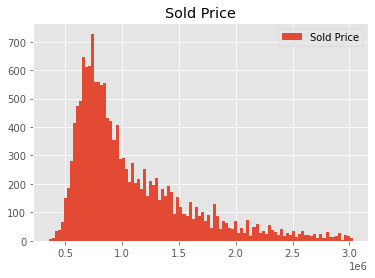

In [73]:
House_dataset.hist("Sold Price",bins=100)
plt.legend(labels=['Sold Price'])

In [74]:
House_dataset["log price"]=np.log(House_dataset['Sold Price'].tolist())
print(House_dataset["log price"].describe())

count    15224.000000
mean        13.799306
std          0.412670
min         12.779873
25%         13.487006
50%         13.710150
75%         14.077875
max         14.924073
Name: log price, dtype: float64


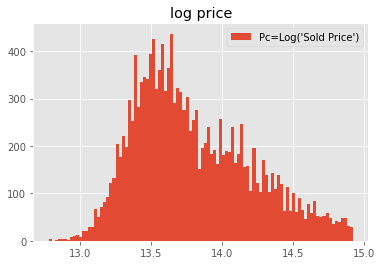

In [75]:
House_dataset.hist("log price",bins=100)
plt.legend(labels=["Pc=Log('Sold Price')"])

In [76]:
# creat classes for sold price labl
#df1['score_floor'] = df1['Score'].apply(np.floor)
House_dataset["price class"]=round((House_dataset['Sold Price']-400000)/100000).astype(int)
House_dataset["price class"].value_counts().sort_index()

0       67
1      482
2     1720
3     2211
4     2285
5     1463
6     1187
7      761
8      868
9      649
10     686
11     406
12     430
13     310
14     345
15     190
16     199
17     136
18     171
19     125
20     122
21      76
22      96
23      54
24      85
25      55
26      45
Name: price class, dtype: int64

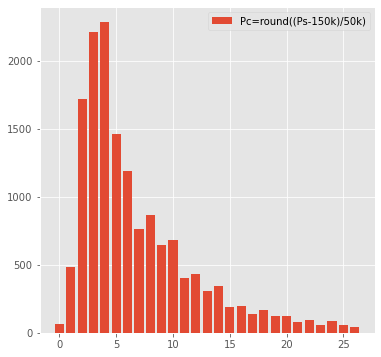

In [77]:
#House_dataset["price class"].value_counts().sort_index()
fig = plt.figure(figsize =(6,6))
ss=House_dataset['price class'].value_counts().sort_index()
plt.bar(list(ss.keys()),list(ss.values))
plt.legend(labels=["Pc=round((Ps-150k)/50k)"])

In [78]:
print(House_dataset["List Price"].describe())

count    1.522400e+04
mean     1.012378e+06
std      4.942451e+05
min      2.990000e+05
25%      6.888000e+05
50%      8.490000e+05
75%      1.199000e+06
max      3.510000e+06
Name: List Price, dtype: float64


In [79]:
print(House_dataset['Days on Market'].describe())

count    15224.000000
mean        13.553665
std         17.611368
min          0.000000
25%          5.000000
50%          7.000000
75%         14.000000
max        535.000000
Name: Days on Market, dtype: float64


In [80]:
print(House_dataset['Date'].describe())

count    15224.000000
mean        10.879401
std          6.714574
min          0.000000
25%          5.000000
50%         10.000000
75%         16.000000
max         24.000000
Name: Date, dtype: float64


In [81]:
House_dataset["MortgageRate"]

619      3.14
620      3.34
623      3.14
624      3.24
625      3.14
         ... 
32152    3.14
32444    3.14
33399    3.09
33437    3.14
33757    3.14
Name: MortgageRate, Length: 15224, dtype: float64

In [82]:
House_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15224 entries, 619 to 33757
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bedrooms AG           15224 non-null  float64
 1   Bedrooms BG           15224 non-null  float64
 2   Washrooms             15224 non-null  int64  
 3   Family Room           15224 non-null  int64  
 4   Parking Type          15224 non-null  int64  
 5   Taxes                 15224 non-null  float64
 6   AC Type               15224 non-null  int64  
 7   green_new             15224 non-null  float64
 8   Date                  15224 non-null  int64  
 9   MortgageRate          15224 non-null  float64
 10  Sale to List %        15224 non-null  float64
 11  Days on Market        15224 non-null  int64  
 12  List Price            15224 non-null  int64  
 13  Sold Price            15224 non-null  int64  
 14  Detached              15224 non-null  int64  
 15  Semi-Detached    

In [83]:
corr=House_dataset.corr(method ='pearson')
#corr
corr[abs(corr["price class"])>0.5][["log price"]]


,log price
Taxes,0.847109
List Price,0.926035
Sold Price,0.971874
log price,1.000000
price class,0.970420


In [84]:
House_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15224 entries, 619 to 33757
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bedrooms AG           15224 non-null  float64
 1   Bedrooms BG           15224 non-null  float64
 2   Washrooms             15224 non-null  int64  
 3   Family Room           15224 non-null  int64  
 4   Parking Type          15224 non-null  int64  
 5   Taxes                 15224 non-null  float64
 6   AC Type               15224 non-null  int64  
 7   green_new             15224 non-null  float64
 8   Date                  15224 non-null  int64  
 9   MortgageRate          15224 non-null  float64
 10  Sale to List %        15224 non-null  float64
 11  Days on Market        15224 non-null  int64  
 12  List Price            15224 non-null  int64  
 13  Sold Price            15224 non-null  int64  
 14  Detached              15224 non-null  int64  
 15  Semi-Detached    

In [85]:
House_dataset.to_csv("House_dataset.csv",index=False)
pd.read_csv("House_dataset.csv")

,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Parking Type,Taxes,AC Type,green_new,Date,MortgageRate,...,W10,W05,E06,E02,C09,E01,W01,E07,log price,price class
0,5.0,1.0,6,1,1,11915.00,1,13.089583,16,3.14,...,0,0,0,0,0,0,0,0,14.924073,26
1,4.0,1.0,5,1,1,9800.00,1,29.295208,24,3.34,...,0,0,0,0,0,0,0,0,14.924073,26
2,3.0,1.0,4,1,1,14530.00,1,27.621771,9,3.14,...,0,0,0,0,0,0,0,0,14.922422,26
3,4.0,1.0,6,1,1,10532.87,1,24.436771,22,3.24,...,0,0,0,0,0,0,0,0,14.922422,26
4,4.0,1.0,4,1,1,13401.73,1,31.939375,17,3.14,...,0,0,0,0,0,0,0,0,14.920767,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15219,3.0,0.0,3,0,1,1924.53,1,31.006250,3,3.14,...,0,0,0,0,0,0,0,0,12.847927,0
15220,3.0,0.0,1,0,0,3096.00,1,24.252400,2,3.14,...,0,0,0,0,0,0,0,0,12.834681,0
15221,2.0,0.0,1,0,0,1953.84,0,2.445830,20,3.09,...,0,0,0,0,0,0,0,0,12.793859,0
15222,2.0,1.0,1,0,0,1596.10,0,22.420900,5,3.14,...,0,0,0,0,0,0,0,0,12.793859,0


In [86]:
#Heat Maps
#fig=plt.gcf()
#fig.set_size_inches(10,7)
#fig=sns.heatmap(corr[corr>0.2],annot=True,cmap='cubehelix',linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)